## Trabalho de Conclusão de Semestre - Redes Neurais e Algoritmos Genéticos
<p align = 'center'> <h2> Predições Climáticas: </h2></p>
<p align = 'center'> <h3> O uso de Redes Neurais para análise da influência de temperatura na superfície marítma em locais de ocorrência do fenômeno 'El Niño'</h3> </p>

#### Autores:
Alice Kageyama (220049), Haziel Sixto Baden Sanchez Hermoza (220065), Monyque Karoline de Paula Silva (220063), Pedro Thomazelli Ferreira (220058)

<hr>

In [1]:
# Importações:

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import MeanAbsolutePercentageError

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

c:\venv\ilumpy\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Setup inicial:

TAMANHO_TESTE = 0.1
SEMENTE_ALEATORIA = 61455
ARQUIVO = 'dados/elnino.csv'

df = pd.read_csv(ARQUIVO, header=0)
df = df.drop(columns=['Observation', ' Date'])

# Removendo dados faltantes:
df = df[df != '.']
df.dropna(how='any', inplace=True)
df = df.astype(float)
df = df.reset_index(drop=True)

display(df)

,Year,Month,Day,Latitude,Longitude,Zonal Winds,Meridional Winds,Humidity,Air Temp,Sea Surface Temp
0,93.0,5.0,9.0,-0.02,-109.96,-2.1,2.1,81.2,26.80,27.02
1,93.0,5.0,10.0,-0.02,-109.96,-3.4,1.4,84.2,26.95,26.91
2,93.0,5.0,11.0,-0.02,-109.96,-3.8,2.2,84.9,26.98,26.78
3,93.0,5.0,12.0,-0.02,-109.96,-3.0,1.5,86.9,26.93,26.74
4,93.0,5.0,13.0,-0.02,-109.96,-4.5,1.9,87.6,27.01,26.82
...,...,...,...,...,...,...,...,...,...,...
93930,98.0,6.0,10.0,8.95,-140.33,-6.8,-5.3,81.3,27.52,28.17
93931,98.0,6.0,11.0,8.96,-140.33,-5.1,-0.4,94.1,26.04,28.14
93932,98.0,6.0,12.0,8.96,-140.32,-4.3,-3.3,93.2,25.80,27.87
93933,98.0,6.0,13.0,8.95,-140.34,-6.1,-4.8,81.3,27.17,27.93


In [3]:
# Definindo os dados de treino e teste:

FEATURES = [df.columns[0],df.columns[1],df.columns[2],df.columns[3],df.columns[4],df.columns[5],df.columns[6],df.columns[7],df.columns[8]]
TARGET = [df.columns[9]]

indices = df.index

indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

x_treino = df_treino.reindex(FEATURES, axis=1)
y_treino = df_treino.reindex(TARGET, axis=1)
x_teste = df_teste.reindex(FEATURES, axis=1)
y_teste = df_teste.reindex(TARGET, axis=1)

In [4]:
# Normalização:

normalizador_x = MinMaxScaler()
normalizador_y = MinMaxScaler()

normalizador_x.fit(x_treino)
normalizador_y.fit(y_treino)

x_treino = normalizador_x.transform(x_treino)
y_treino = normalizador_y.transform(y_treino)
x_teste = normalizador_x.transform(x_teste)
y_teste = normalizador_y.transform(y_teste)

In [5]:
# Criando tensores:

x_treino = torch.tensor(x_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)
x_teste = torch.tensor(x_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [6]:
# Checando os dados:

print(x_treino)
print()
print(y_treino)

tensor([[0.4444, 1.0000, 0.3000,  ..., 0.4110, 0.6862, 0.7207],
        [0.8889, 0.4545, 0.1667,  ..., 0.5169, 0.6130, 0.8314],
        [0.7778, 0.9091, 0.0000,  ..., 0.4195, 0.6841, 0.4884],
        ...,
        [0.4444, 0.3636, 0.4333,  ..., 0.3856, 0.7301, 0.6780],
        [0.8889, 0.6364, 0.0000,  ..., 0.3051, 0.6025, 0.7359],
        [0.3333, 0.4545, 0.9000,  ..., 0.4831, 0.6506, 0.5810]])

tensor([[0.8132],
        [0.8444],
        [0.4786],
        ...,
        [0.7121],
        [0.8444],
        [0.5377]])


In [7]:
# Criando a classe da rede neural:

class OS_MENININHOS(nn.Module):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        super().__init__()

        # Definindo as camadas da rede:
        
        self.camadas = nn.Sequential(
                    nn.Linear(num_dados_entrada, neuronios_c1),
                    nn.ReLU(),
                    nn.Linear(neuronios_c1, neuronios_c2),
                    nn.ReLU(),
                    nn.Linear(neuronios_c2, num_targets),
                )

    def forward(self, x):
        """ Esse é o método que executa a rede do pytorch."""
        x = self.camadas(x)
        return x

In [8]:
# Criando uma instância da rede:

NUM_DADOS_DE_ENTRADA = x_treino.shape[1]
NUM_DADOS_DE_SAIDA = y_treino.shape[1]
NEURONIOS_C1 = 150
NEURONIOS_C2 = 63

minha_redezinha = OS_MENININHOS(NUM_DADOS_DE_ENTRADA, NEURONIOS_C1, NEURONIOS_C2, NUM_DADOS_DE_SAIDA)

In [9]:
# Checando os parâmetros internos:

for p in minha_redezinha.parameters():
    print(p)

Parameter containing:
tensor([[ 0.2981,  0.0662, -0.0575,  ...,  0.1884,  0.2515, -0.0684],
        [-0.2865,  0.0731, -0.1664,  ..., -0.0821,  0.2382,  0.0534],
        [ 0.2159,  0.3161,  0.1619,  ..., -0.1009,  0.0465,  0.2965],
        ...,
        [ 0.1848,  0.0175, -0.3319,  ..., -0.2339,  0.2288, -0.2286],
        [ 0.1788, -0.0594,  0.1218,  ..., -0.0683, -0.0958,  0.0750],
        [-0.2121,  0.2652, -0.2051,  ...,  0.0005, -0.2847, -0.1502]],
       requires_grad=True)
Parameter containing:
tensor([ 1.3927e-01,  2.4789e-01,  3.2440e-01, -4.1663e-02,  1.0204e-01,
        -9.0146e-02, -2.4554e-01,  1.5360e-01,  1.4668e-01, -2.2998e-01,
         2.4345e-01, -2.1703e-01, -1.8775e-01,  2.0896e-01, -2.8842e-01,
        -1.2935e-01, -3.1374e-01,  1.1195e-01, -7.6866e-02, -4.9943e-02,
         5.4926e-03, -7.5035e-02,  1.0502e-01,  3.8085e-02,  5.1154e-02,
        -2.8168e-01,  3.2744e-01,  2.0515e-01, -5.1305e-02,  1.8406e-01,
        -3.3292e-01,  2.0727e-01,  1.8972e-01,  1.0831e-0

In [10]:
# Primeiro teste de previsão (ruinzinha):

y_prev = minha_redezinha(x_treino)
y_prev

tensor([[0.1227],
        [0.1075],
        [0.1201],
        ...,
        [0.1190],
        [0.1031],
        [0.1495]], grad_fn=<AddmmBackward>)

In [11]:
# Usando o otimizador (Adam):

TAXA_DE_APRENDIZADO = 0.001

# A função perda será o erro quadrático médio:
fn_perda = nn.MSELoss()

# O otimizador será o Adam, um tipo de descida do gradiente:
otimizador = optim.Adam(minha_redezinha.parameters(), lr=TAXA_DE_APRENDIZADO)

In [12]:
# Treinando a rede:

# Colocando ela no "modo treino":
minha_redezinha.train()

NUM_EPOCAS = 1000

y_true = y_treino

for epoca in range(NUM_EPOCAS):
    # Forward pass:
    y_pred = minha_redezinha(x_treino)

    # Zero grad:
    otimizador.zero_grad()

    # Loss:
    loss = fn_perda(y_pred, y_true)

    # Backpropagation:
    loss.backward()

    # atualiza parâmetros
    otimizador.step()

    # Exibe o resultado:
    print(epoca, loss.data)

0 tensor(0.4098)
1 tensor(0.3490)
2 tensor(0.2915)
3 tensor(0.2377)
4 tensor(0.1887)
5 tensor(0.1453)
6 tensor(0.1081)
7 tensor(0.0777)
8 tensor(0.0542)
9 tensor(0.0375)
10 tensor(0.0277)
11 tensor(0.0243)
12 tensor(0.0264)
13 tensor(0.0323)
14 tensor(0.0398)
15 tensor(0.0464)
16 tensor(0.0505)
17 tensor(0.0516)
18 tensor(0.0498)
19 tensor(0.0460)
20 tensor(0.0410)
21 tensor(0.0357)
22 tensor(0.0308)
23 tensor(0.0268)
24 tensor(0.0239)
25 tensor(0.0222)
26 tensor(0.0214)
27 tensor(0.0214)
28 tensor(0.0219)
29 tensor(0.0226)
30 tensor(0.0234)
31 tensor(0.0240)
32 tensor(0.0244)
33 tensor(0.0244)
34 tensor(0.0241)
35 tensor(0.0234)
36 tensor(0.0225)
37 tensor(0.0215)
38 tensor(0.0204)
39 tensor(0.0193)
40 tensor(0.0184)
41 tensor(0.0176)
42 tensor(0.0171)
43 tensor(0.0168)
44 tensor(0.0167)
45 tensor(0.0167)
46 tensor(0.0167)
47 tensor(0.0166)
48 tensor(0.0165)
49 tensor(0.0162)
50 tensor(0.0157)
51 tensor(0.0152)
52 tensor(0.0147)
53 tensor(0.0142)
54 tensor(0.0137)
55 tensor(0.0133)
56

In [ ]:
# Checando a performance da rede:

with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_treino)
    y_pred = minha_redezinha(x_treino)
    y_pred = normalizador_y.inverse_transform(y_pred)

for yt, yp in zip(y_true, y_pred):
    print(yt, yp)

[28.63999986] [28.3028849]
[29.03999988] [29.75701636]
[24.33999998] [24.46650579]
[25.92] [26.39596471]
[26.95000037] [27.14136387]
[29.14999973] [29.44973245]
[23.66999987] [23.90039923]
[28.01000028] [26.81906716]
[26.70000035] [26.63612955]
[28.88999987] [29.28196846]
[28.77000017] [28.26765719]
[30.2999998] [29.98888552]
[29.23999989] [29.1420043]
[23.83000011] [23.93420156]
[29.38000005] [29.2260816]
[29.44999975] [28.51753619]
[29.78000008] [29.67075695]
[28.88999987] [28.59796695]
[28.39999969] [28.33656546]
[25.58999968] [26.76758434]
[29.63999992] [29.66273394]
[28.63000001] [28.797211]
[30.33000011] [29.97623023]
[25.31999997] [25.37633719]
[27.32000008] [28.01049583]
[27.58999979] [27.06339248]
[29.14999973] [29.88349498]
[24.36000006] [24.94553034]
[28.73999986] [28.45956526]
[28.58000001] [28.85260001]
[27.78999981] [27.46059383]
[29.54999976] [29.88297415]
[29.3899999] [29.31605112]
[28.02999997] [28.13226787]
[25.87] [26.28267982]
[25.02999979] [25.23868151]
[26.1100001

In [ ]:
# Testando a rede:

# Colocando ela no "modo avaliação":
minha_redezinha.eval()

with torch.no_grad():
    y_true = normalizador_y.inverse_transform(y_teste)
    y_pred = minha_redezinha(x_teste)
    y_pred = normalizador_y.inverse_transform(y_pred)

for yt, yp in zip(y_true, y_pred):
    print(yt, yp)

[26.97000006] [27.08211998]
[28.32999999] [29.04522269]
[28.78999987] [28.88141085]
[29.61000037] [29.6762486]
[27.27999993] [27.42590457]
[23.80000018] [23.34186226]
[27.72999996] [27.95643262]
[28.88000002] [29.48115047]
[29.23000005] [27.82334948]
[25.86000015] [25.37571756]
[29.01000034] [28.81757297]
[30.2999998] [30.37467544]
[29.18999989] [29.31660641]
[29.14999973] [29.29091134]
[28.43999985] [28.06461418]
[29.47000021] [29.34032695]
[29.06000034] [29.05473005]
[28.93000003] [28.72106709]
[29.4399999] [29.53331803]
[29.2700002] [29.66044078]
[29.90999963] [29.87653813]
[30.25999965] [30.42073325]
[29.54999976] [29.13477631]
[28.17000014] [28.66105422]
[28.71000032] [28.60426128]
[28.13999983] [27.69024719]
[29.71000038] [28.93262943]
[29.74999977] [29.78384346]
[28.93000003] [29.56543993]
[24.41999991] [24.5811678]
[23.23999992] [24.54209057]
[28.03999982] [28.3447922]
[29.18999989] [29.01060388]
[29.53999991] [29.21249342]
[27.5700001] [27.02080275]
[26.57000004] [26.65865141]

In [ ]:
# Medindo a performance com RMSE:

RMSE = mean_squared_error(y_true, y_pred, squared=False)
print(f'Loss do teste: {RMSE}')

Loss do teste: 0.4237691885828286


In [ ]:
# Medindo a performance com MAPE:
target = torch.tensor([1, 10, 1e6])
preds = torch.tensor([0.9, 15, 1.2e6])
MAPE = MeanAbsolutePercentageError()
print(f'Loss do teste: {MAPE(preds, target)}')

Loss do teste: 0.2666666805744171


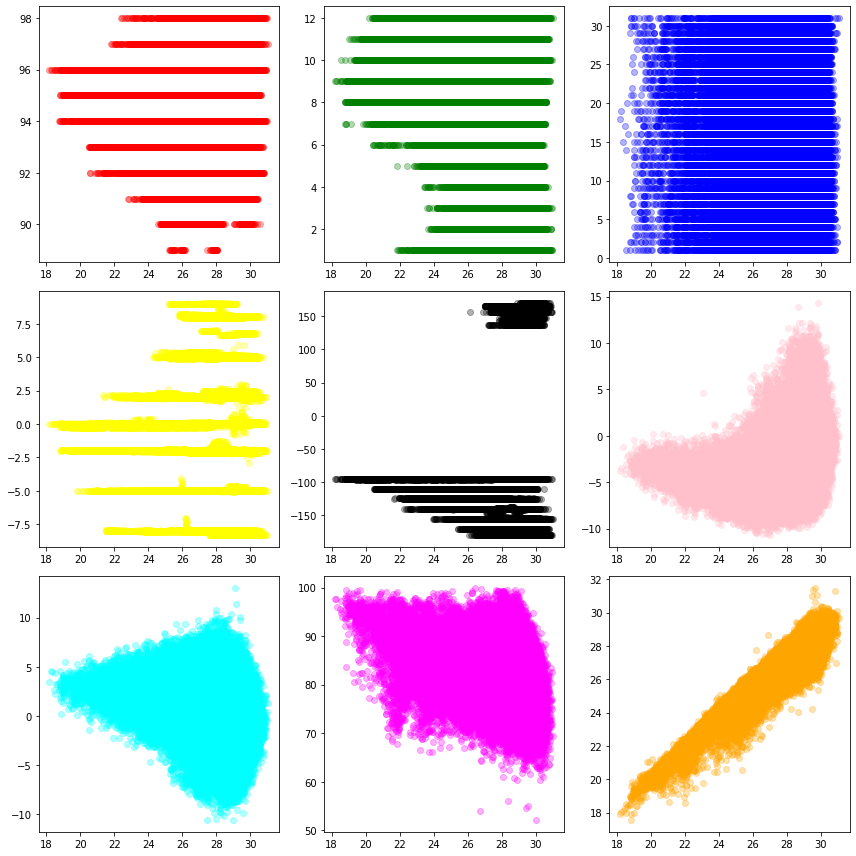

In [ ]:
# Plotando scatter plots para cada feature em relação ao target:

fig, axs = plt.subplots(3,3,figsize = (12,12))
axs = axs.flatten()
for (i, ax), cor in zip(enumerate(axs),['r', 'g', 'b', 'yellow', 'k', 'pink', 'cyan', 'magenta', 'orange']):
    ax.scatter(list(df[TARGET[0]]), list(df[FEATURES[i]]), color=cor, alpha=0.3)
    
plt.tight_layout()
plt.show()

In [ ]:
# Matriz de covâriancia
df_covariancia = df.cov()

# Matriz de correlação
df_correlacao = df.corr()

print('Matriz de covariância: ')
df_covariancia

print('\n\nMatriz de correlação: ')
df_correlacao

Matriz de covariância: 


Matriz de correlação: 


,Year,Month,Day,Latitude,Longitude,Zonal Winds,Meridional Winds,Humidity,Air Temp,Sea Surface Temp
Year,1.000000,-0.186230,-0.016503,0.022339,-0.034951,0.026287,-0.085108,-0.011785,0.055755,0.053689
Month,-0.186230,1.000000,0.013974,-0.001173,-0.008976,0.063149,0.265413,-0.132518,-0.134154,-0.098813
Day,-0.016503,0.013974,1.000000,-0.001630,-0.002007,0.005034,0.005668,-0.000252,-0.007448,-0.004826
Latitude,0.022339,-0.001173,-0.001630,1.000000,0.096651,0.117911,-0.092178,0.158111,0.076123,0.125119
Longitude,-0.034951,-0.008976,-0.002007,0.096651,1.000000,0.364256,-0.024335,-0.042777,0.249050,0.304027
Zonal Winds,0.026287,0.063149,0.005034,0.117911,0.364256,1.000000,0.079763,0.063553,0.233156,0.376015
Meridional Winds,-0.085108,0.265413,0.005668,-0.092178,-0.024335,0.079763,1.000000,0.077647,-0.339254,-0.284897
Humidity,-0.011785,-0.132518,-0.000252,0.158111,-0.042777,0.063553,0.077647,1.000000,-0.388059,-0.324348
Air Temp,0.055755,-0.134154,-0.007448,0.076123,0.249050,0.233156,-0.339254,-0.388059,1.000000,0.940233
Sea Surface Temp,0.053689,-0.098813,-0.004826,0.125119,0.304027,0.376015,-0.284897,-0.324348,0.940233,1.000000


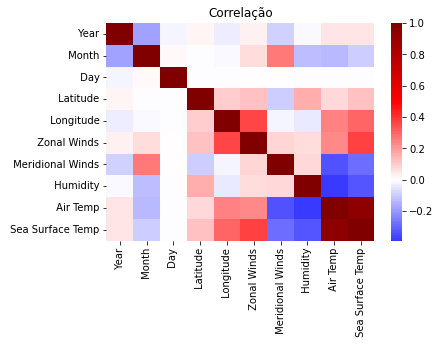

In [ ]:
#Criando um mapa de cores dos valoes da correlação
sns.heatmap(df_correlacao, 
        xticklabels=df_correlacao.columns,
        yticklabels=df_correlacao.columns,
           cmap='seismic',
           center = 0)

plt.title('Correlação')
plt.show()

In [ ]:
## shap.summary_plot(shap_values, features=x_samples, feature_names=features)

NameError: name 'shap' is not defined

In [ ]:
# Create a SHAP explainer
#explainer = shap.DeepExplainer(camadas, df)

# Calculate SHAP values for your dataset
shap_values = explainer.shap_values(df)

# Plot the feature importance using a summary plot
#shap.summary_plot(shap_values, df)

NameError: name 'shap' is not defined